In [1]:
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import datetime as dt
import urllib.request
import json
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
data_source = 'alphavantage'
tick = "TCS"

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7TONQ8CM5PXZ4YEO'

    # TCS stock market prices
    ticker = tick

    # JSON file with all the stock market data for TCS
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s" % (
        ticker, api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv' % ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(
                columns=['Date', 'Low', 'High', 'Close', 'Open'])
            for k, v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(), float(v['3. low']), float(v['2. high']),
                            float(v['4. close']), float(v['1. open'])]
                df.loc[-1, :] = data_row
                df.index = df.index + 1
        print('Data saved to : %s' % file_to_save)
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)


File already exists. Loading data from CSV


In [3]:
file_name = "stock_market_data-" + tick + ".csv"
df = pd.read_csv(file_name)

df = df[['Date', 'Open', 'Close', 'Low', 'High']]

df = df.sort_values('Date')

high_prices = df.loc[:, 'High']
low_prices = df.loc[:, 'Low']
df["Mid Prices"] = (high_prices + low_prices) / 2.0

df.drop("Date", axis=1, inplace=True)


Most recent 2018-11-23

In [4]:
df.tail()

,Open,Close,Low,High,Mid Prices
4,5.94,5.73,5.535,5.95,5.7425
3,5.71,5.64,5.600,5.84,5.7200
2,5.51,5.56,5.360,5.64,5.5000
1,5.60,5.75,5.530,5.77,5.6500
0,5.69,5.65,5.620,5.77,5.6950


In [5]:
def load_data(stock, seq_len):
    amount_of_features = 5
    data = stock
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.75 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:, -1]

    x_train = np.reshape(
        x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(
        x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return [x_train, y_train, x_test, y_test]


In [6]:
df1 = df
df = df.values

In [7]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [8]:
window = 5
X_train, y_train, X_test, y_test = load_data(df, window)

In [9]:
X_test.shape

(317, 5, 5)

In [10]:
x_latest = df[-5:]

In [11]:
x_latest = np.reshape(x_latest, (1, x_latest.shape[0], window))

In [12]:
df1.describe()

,Open,Close,Low,High,Mid Prices
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,13.156808,13.132157,12.840747,13.442216,13.141482
std,10.331883,10.279513,10.069223,10.504556,10.285317
min,3.550000,3.560000,3.530000,3.690000,3.610000
25%,5.300000,5.300000,5.190000,5.393000,5.282250
50%,7.890000,7.910000,7.680000,8.210000,7.930000
75%,18.705000,18.720000,18.462600,19.140000,18.742500
max,46.870000,46.610000,45.600000,47.070000,46.335000


In [13]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=50,
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print('compilation time : ', time.time() - start)
    return model


In [14]:
model = build_model([5, window, 1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=15,
    validation_split=0.1,
    verbose=1)

compilation time :  0.020542621612548828
Train on 856 samples, validate on 96 samples
Epoch 1/15
856/856 [==============================] - 1s 2ms/step - loss: 0.1279 - val_loss: 0.0019
Epoch 2/15
856/856 [==============================] - 0s 135us/step - loss: 0.0294 - val_loss: 0.0089
Epoch 3/15
856/856 [==============================] - 0s 120us/step - loss: 0.0057 - val_loss: 0.0068
Epoch 4/15
856/856 [==============================] - 0s 138us/step - loss: 0.0045 - val_loss: 0.0047
Epoch 5/15
856/856 [==============================] - 0s 119us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 6/15
856/856 [==============================] - 0s 140us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 7/15
856/856 [==============================] - 0s 111us/step - loss: 0.0027 - val_loss: 0.0011
Epoch 8/15
856/856 [==============================] - 0s 145us/step - loss: 0.0025 - val_loss: 6.2659e-04
Epoch 9/15
856/856 [==============================] - 0s 117us/step - loss: 0.0033 - val_loss: 2

In [15]:
trainScore = model.evaluate(X_train, y_train, verbose=0)

accuracy_train = (1 - trainScore) * 100

# Predictions

p = model.predict(X_test)

mse = mean_squared_error(y_test, p)

accuracy_test = (1 - mse) * 100

# in case want to display accuracy use
# return(p, y_test, accuracy_train, accuracy_test)
p = np.reshape(p, p.shape[0]).tolist()
y_test = np.reshape(y_test, y_test.shape[0]).tolist()

def delete_stock_data(file_name):
    if os.path.exists(file_name):
        os.remove(file_name)
        print("File removed successfully")
    else:
        print("The file does not exist")

# delete_stock_data(file_name)

In [16]:
trainScore

0.0034782109399531095

In [17]:
p_latest = model.predict(x_latest)
p.append(p_latest)

In [18]:
def inverse_minmax(x, maxval, minval):
    return (x*(maxval-minval)+minval)

In [19]:
maxval = max(df1['Mid Prices'])
minval = min(df1['Mid Prices'])

In [20]:
p = [inverse_minmax(y, maxval, minval) for y in p]
y_test = [inverse_minmax(y, maxval, minval) for y in y_test]

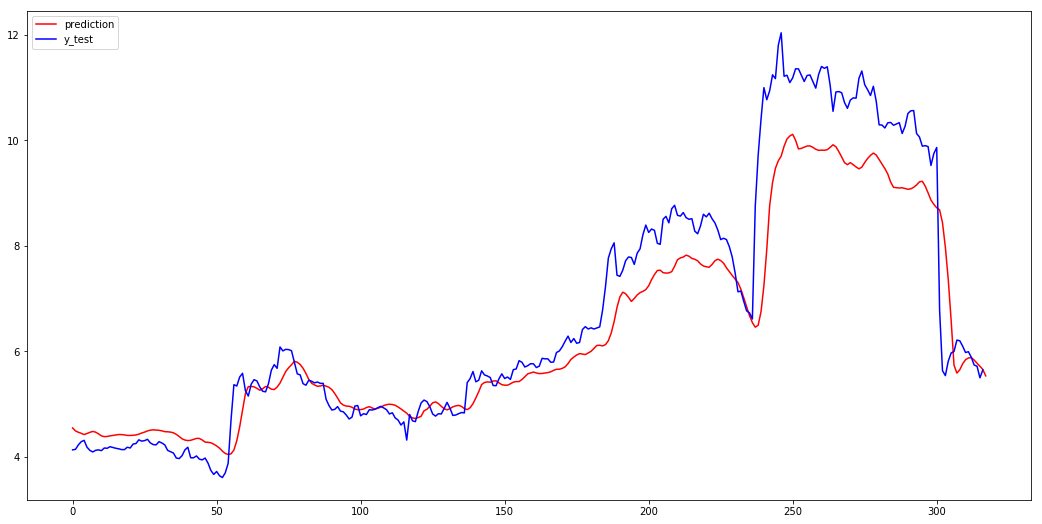

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt2
plt2.figure(figsize = (18,9))
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [22]:
p_latest = model.predict(x_latest)
p_latest = inverse_minmax(p_latest[0,0], maxval, minval)

In [23]:
p_latest

5.536999513059854